In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Load the dataset
df = pd.read_csv(r"C:\Users\User\Downloads\Anaconda\QDL-FON\QDL-FON.csv")


In [5]:
print(df.shape)
print(df.columns)
print(df.info())
print(df.isnull().sum())
print(df.describe(include='all'))


(10000, 19)
Index(['contract_code', 'type', 'date', 'market_participation',
       'producer_merchant_processor_user_longs',
       'producer_merchant_processor_user_shorts', 'swap_dealer_longs',
       'swap_dealer_shorts', 'swap_dealer_spreads', 'money_manager_longs',
       'money_manager_shorts', 'money_manager_spreads',
       'other_reportable_longs', 'other_reportable_shorts',
       'other_reportable_spreads', 'total_reportable_longs',
       'total_reportable_shorts', 'non_reportable_longs',
       'non_reportable_shorts'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   contract_code                            10000 non-null  object 
 1   type                                     10000 non-null  object 
 2   date                                     10000

In [7]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')


In [8]:
df = df[df.isnull().mean(axis=1) < 0.5]


In [9]:
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(0)


In [10]:
df['total_open_interest'] = df[['total_reportable_longs', 'total_reportable_shorts']].max(axis=1)

# Example threshold-based concentration
df['concentration_risk'] = (
    (df['producer_merchant_processor_user_longs'] > 0.4 * df['total_open_interest']) |
    (df['money_manager_longs'] > 0.4 * df['total_open_interest'])
).astype(int)


In [11]:
df.drop(['contract_code', 'type', 'date'], axis=1, inplace=True)


In [12]:
X = df.drop('concentration_risk', axis=1)
y = df['concentration_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(class_weight='balanced', max_iter=5000)
lr.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=5000)

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [17]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [24]:
# Use scaled versions of both X_train and X_test
lr.fit(X_train_scaled, y_train)

models = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'XGBoost': xgb
}

for name, model in models.items():
    if name == 'Logistic Regression':
        preds = model.predict(X_test_scaled)
        proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)[:, 1]

    print(f"Model: {name}")
    print(classification_report(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("=" * 50)


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.55      0.99      0.71       868
           1       0.98      0.35      0.51      1092

    accuracy                           0.63      1960
   macro avg       0.76      0.67      0.61      1960
weighted avg       0.79      0.63      0.60      1960

ROC AUC: 0.9296528164615724
Confusion Matrix:
 [[860   8]
 [711 381]]
Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       868
           1       1.00      1.00      1.00      1092

    accuracy                           1.00      1960
   macro avg       1.00      1.00      1.00      1960
weighted avg       1.00      1.00      1.00      1960

ROC AUC: 0.9999324791951522
Confusion Matrix:
 [[ 864    4]
 [   4 1088]]
Model: XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       868
           1       1.00      0

In [25]:
print(y_train.value_counts(normalize=True))


concentration_risk
1    0.566964
0    0.433036
Name: proportion, dtype: float64


In [27]:
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False).head(10)


,Feature,Importance
1,producer_merchant_processor_user_longs,0.253116
12,total_reportable_longs,0.183042
16,total_open_interest,0.148628
2,producer_merchant_processor_user_shorts,0.093739
13,total_reportable_shorts,0.087165
5,swap_dealer_spreads,0.048719
15,non_reportable_shorts,0.040234
3,swap_dealer_longs,0.036711
0,market_participation,0.023347
14,non_reportable_longs,0.019220


C:\Users\User\AppData\Local\Temp\ipykernel_3728\647687475.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


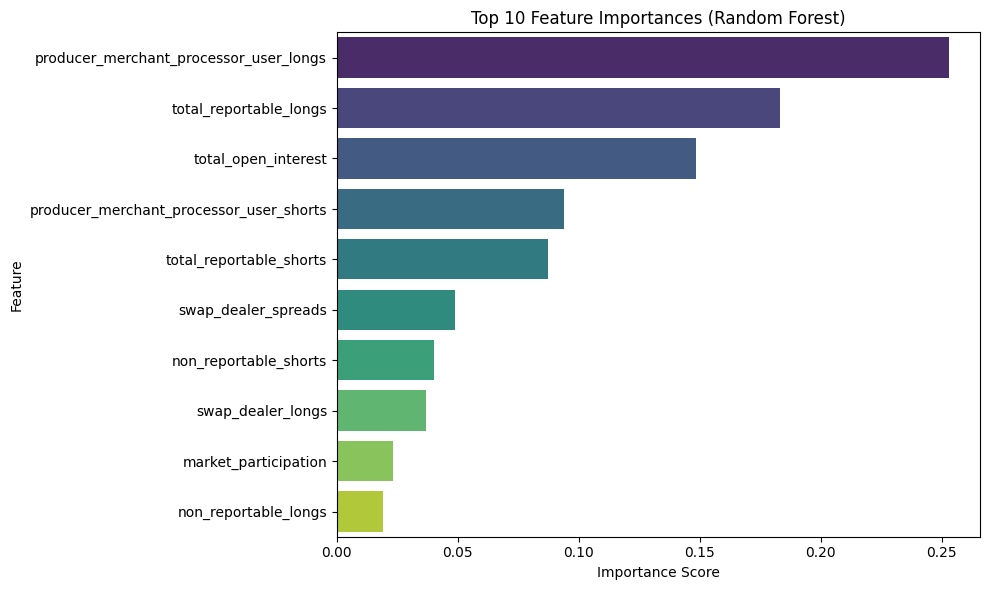

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
